# Image Segmentation: Mask R-CNN

In [ ]:
from __future__ import print_function

import os
import sys
import time
import random
import grpc
import numpy as np
import skimage
import tensorflow as tf
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
import model as modellib
from config import Config

In [2]:
# Set required variables
MODEL_DIR = '/home/<user>/Mask_RCNN'  # Provide the full path to your Mask_RCNN repo directory
ZOO_DIR = '/home/<user>/models'  # Provide the full path to your Model Zoo repo directory
IMAGE_DIR = '/home/<user>/coco/val2014'  # Provide the full path to your COCO validation directory

COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
SERVER_URL = 'localhost:8500'

os.environ["MOUNT_EXTERNAL_MODELS_SOURCE"] = MODEL_DIR
os.environ["MOUNT_BENCHMARK"] = os.path.join(ZOO_DIR, 'benchmark')

In [3]:
# Import visualization tools
sys.path.append(MODEL_DIR)
from mrcnn import visualize

In [ ]:
# Create model object, needed for its data processing methods 
class CocoConfig(Config):
    NAME = "coco"
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 81

class InferenceConfig(CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    
config = InferenceConfig()
config.NUM_INTRA = 16
config.NUM_INTER = 1
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [5]:
# COCO classes
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# Test Image Segmentation

In [6]:
def create_stub_request():
    channel = grpc.insecure_channel(SERVER_URL, options=[
        ('grpc.max_send_message_length', 50 * 1024 * 1024),
        ('grpc.max_receive_message_length', 50 * 1024 * 1024)
        ])
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    request.model_spec.name = 'mask_rcnn'
    request.model_spec.signature_name = 'serving_default'
    return stub, request

In [7]:
# Load a random image from the image directory and mold it into the Mask R-CNN input format
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
molded_images, image_metas, windows = model.mold_inputs([image])

In [ ]:
# Send request to the model server
stub, request = create_stub_request()
request.inputs['input_image'].CopyFrom(tf.contrib.util.make_tensor_proto(molded_images.astype(np.float32)))
request.inputs['input_image_meta'].CopyFrom(tf.contrib.util.make_tensor_proto(image_metas.astype(np.float32)))
result = stub.Predict(request)

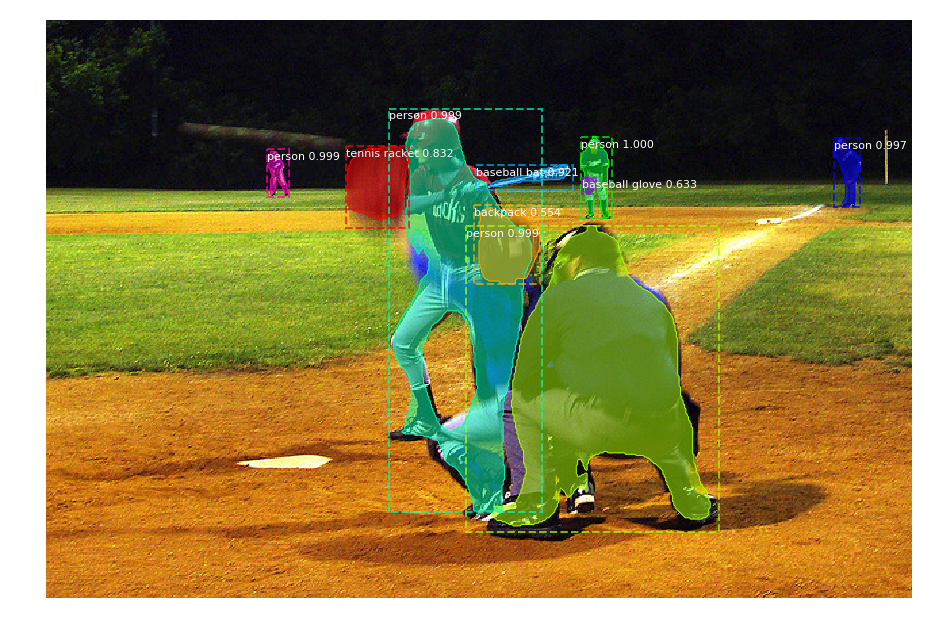

In [9]:
# Format results into unmoldable detections
det_shape = [result.outputs['detection'].tensor_shape.dim[i].size for i in range(3)]
detections =  np.array(result.outputs['detection'].float_val).reshape(det_shape)
mask_shape = [result.outputs['mask'].tensor_shape.dim[i].size for i in range(5)]
masks =  np.array(result.outputs['mask'].float_val).reshape(mask_shape)

# Unmold and display detections
boxes, class_ids, scores, masks = model.unmold_detections(detections[0], masks[0], image.shape, windows[0])
visualize.display_instances(image, boxes, masks, class_ids, class_names, scores)

# Measure Online Inference Performance

In [10]:
def run_model(batch_size=1, num_iteration=20, warm_up_iteration=10):
    i = 0
    total_time = 0
    stub, request = create_stub_request()

    for _ in range(num_iteration):
        i += 1
        image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
        molded_images, image_metas, windows = model.mold_inputs([image])
        request.inputs['input_image'].CopyFrom(tf.contrib.util.make_tensor_proto(molded_images.astype(np.float32)))
        request.inputs['input_image_meta'].CopyFrom(tf.contrib.util.make_tensor_proto(image_metas.astype(np.float32)))
        start_time = time.time()
        result = stub.Predict(request)
        time_consume = time.time() - start_time
        print('Iteration %d: %.3f sec' % (i, time_consume))
        if i > warm_up_iteration:
            total_time += time_consume

    time_average = total_time / (num_iteration - warm_up_iteration)
    print('Average time: %.3f sec' % (time_average))
    print('Batch size = %d' % batch_size)
    if batch_size == 1:
        print('Latency: %.3f ms' % (time_average * 1000))
    print('Throughput: %.3f images/sec' % (batch_size / time_average))

In [ ]:
run_model()